In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import nmmo

from feature_extractor.game_state import GameState
from feature_extractor.entity_helper import EntityHelper
from feature_extractor.map_helper import MapHelper

from scripted import baselines

from lib.team.team_helper import TeamHelper

In [3]:
class Config(nmmo.config.Medium, nmmo.config.AllGameSystems):
  RENDER = False
  SPECIALIZE = True
  PLAYERS = [
    baselines.Fisher, baselines.Herbalist, baselines.Prospector,
    baselines.Carver, baselines.Alchemist,
    baselines.Melee, baselines.Range, baselines.Mage]

config = Config()

In [4]:
# 16 teams x 8 players
num_team = 16
team_size = 8

# match the team definition to the default nmmo
teams = {team_id: [num_team*j+team_id+1 for j in range(team_size)]
          for team_id in range(num_team)}

team_helper = TeamHelper(teams)

In [5]:
RANDOM_SEED = 0
env = nmmo.Env(config, RANDOM_SEED)
init_obs = env.reset()

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [6]:
def _filter_obs(obs, teammates):
  flt_obs = {}
  for ent_id, ent_obs in obs.items():
    if ent_id in teammates:
      flt_obs[ent_id] = ent_obs
  
  return flt_obs

In [7]:
team_id = 5
team_size = len(teams[team_id])
entity_helper = EntityHelper(config, team_helper, team_id)
map_helper = MapHelper(config, entity_helper)
game_state = GameState(config, team_helper.team_size[team_id])

# init the helpers
team_obs = _filter_obs(init_obs, team_helper.teams[team_id])
entity_helper.reset(team_obs)
game_state.reset(team_obs)
map_helper.reset()


In [8]:
# execute step and update the featurizers
for tick in tqdm(range(50)):
  obs, _, _, _ = env.step({})
  team_obs = _filter_obs(obs, team_helper.teams[team_id])    

  game_state.update(team_obs)
  entity_helper.update(team_obs)
  map_helper.update(team_obs, game_state.curr_step)

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [9]:
print('tick:', tick, ', team:', team_id, ', alive agents:', _filter_obs(obs, teams[team_id]).keys())

tick: 49 , team: 5 , alive agents: dict_keys([6, 22, 38, 54, 70, 86, 102, 118])


In [10]:
for tid in range(8):
  print(_filter_obs(obs, teams[tid]).keys())

dict_keys([1, 17, 33, 49, 65, 81, 97, 113])
dict_keys([2, 18, 34, 50, 66, 82, 98, 114])
dict_keys([3, 19, 35, 51, 67, 83, 99, 115])
dict_keys([4, 20, 36, 52, 68, 84, 100, 116])
dict_keys([5, 21, 37, 53, 69, 85, 101, 117])
dict_keys([6, 22, 38, 54, 70, 86, 102, 118])
dict_keys([7, 23, 39, 55, 71, 87, 103, 119])
dict_keys([8, 24, 40, 56, 72, 88, 104, 120])


In [11]:
sub_titles = ['Tile', 'Entity', 'Poison', 'Fog of War', 'Footprint', 'X coord', 'Y coord']

def plot_tile_feats(tile_imgs, agent_idx):
  fig, axs = plt.subplots(2, 4, figsize=(12,6))
  for map_id in range(7):
    axs[map_id//4, map_id%4].imshow(tile_imgs[map_id])
    axs[map_id//4, map_id%4].set_title(sub_titles[map_id])
  
  axs[1,3].axis('off')
  fig.suptitle('Agent ' + str(agent_idx))
  plt.show()

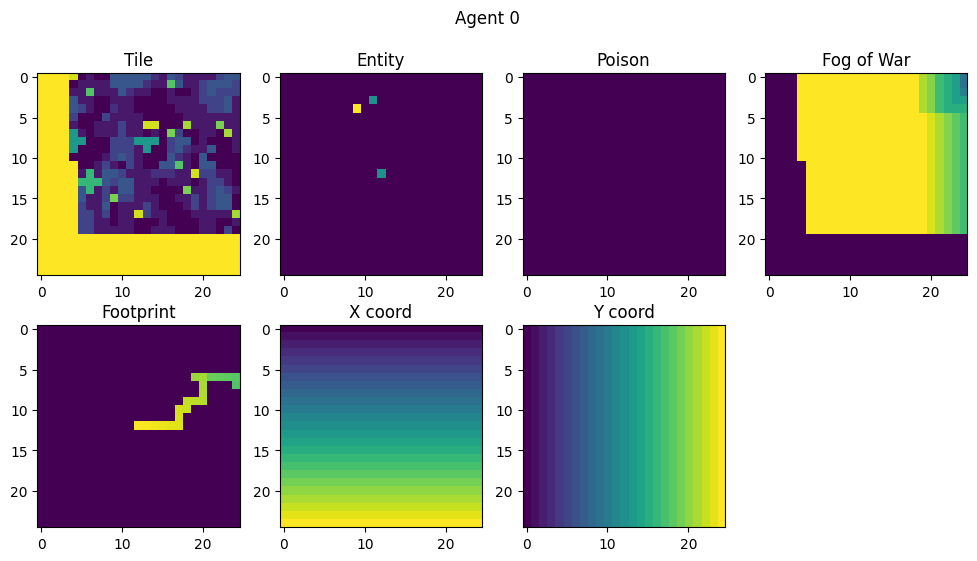

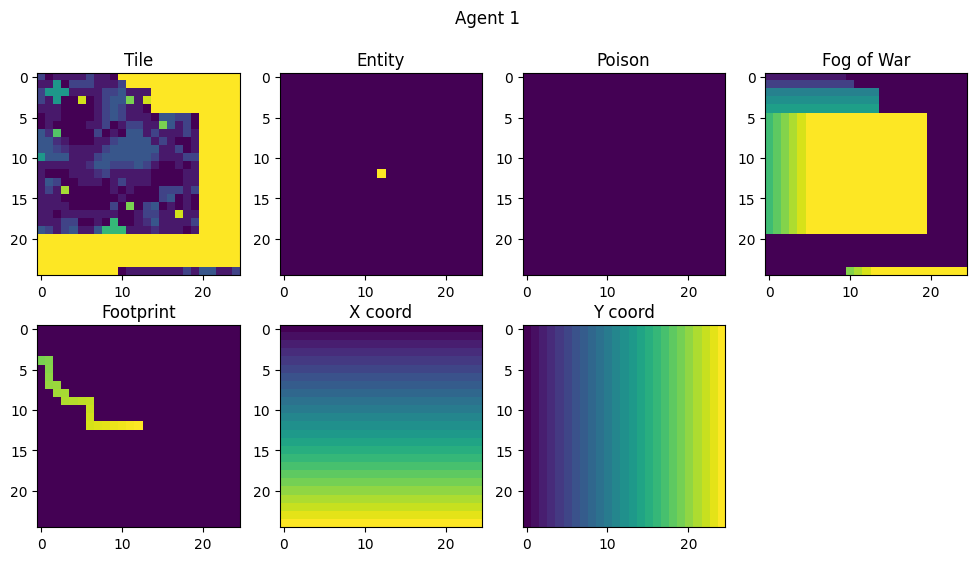

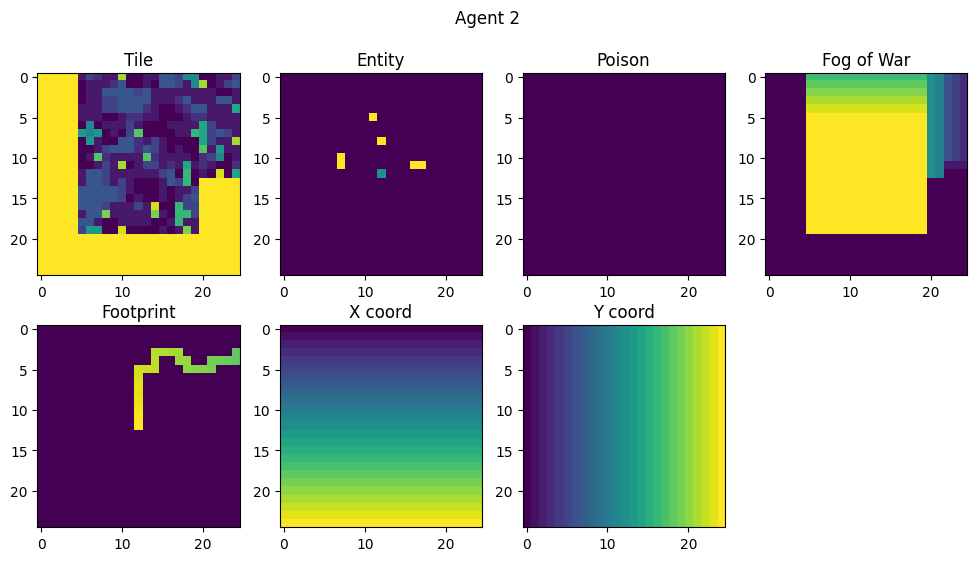

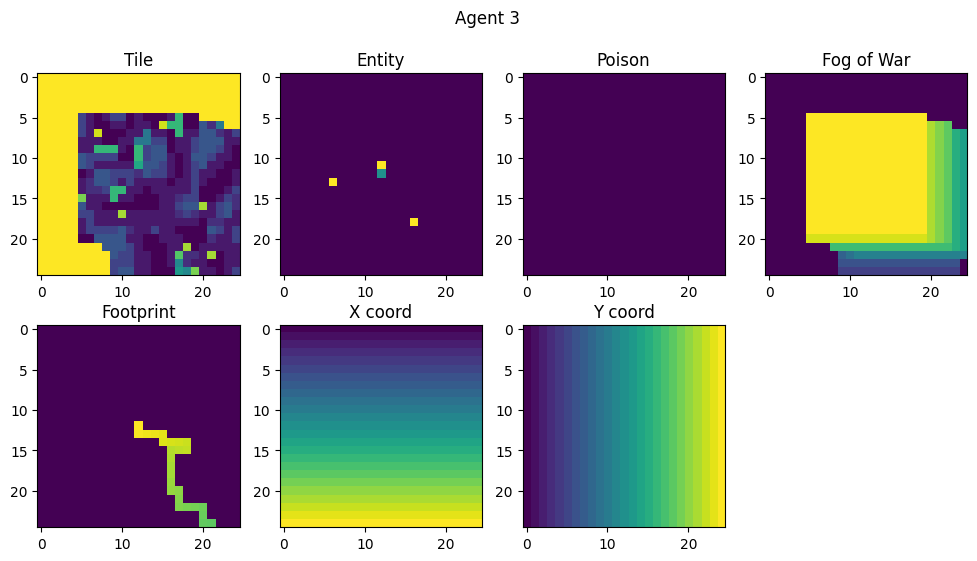

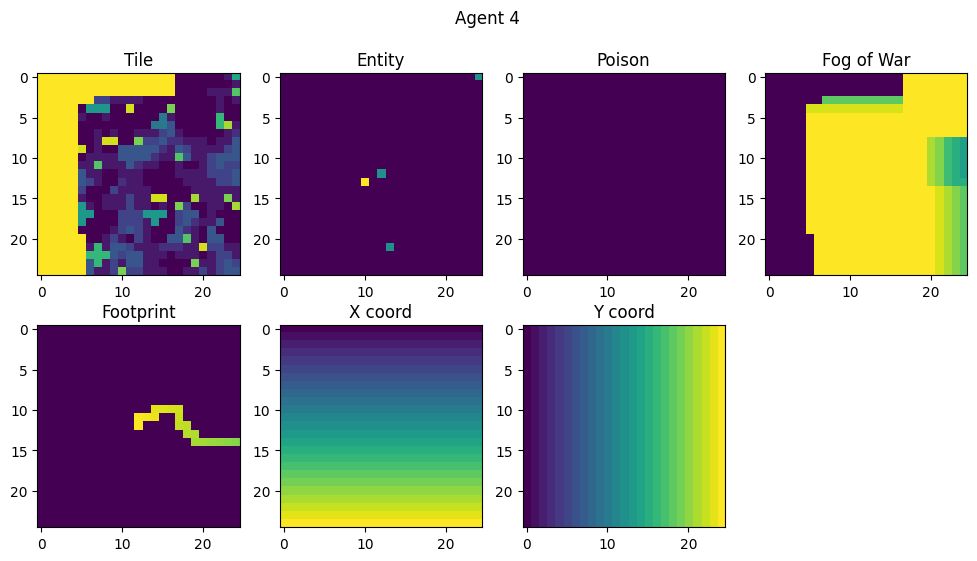

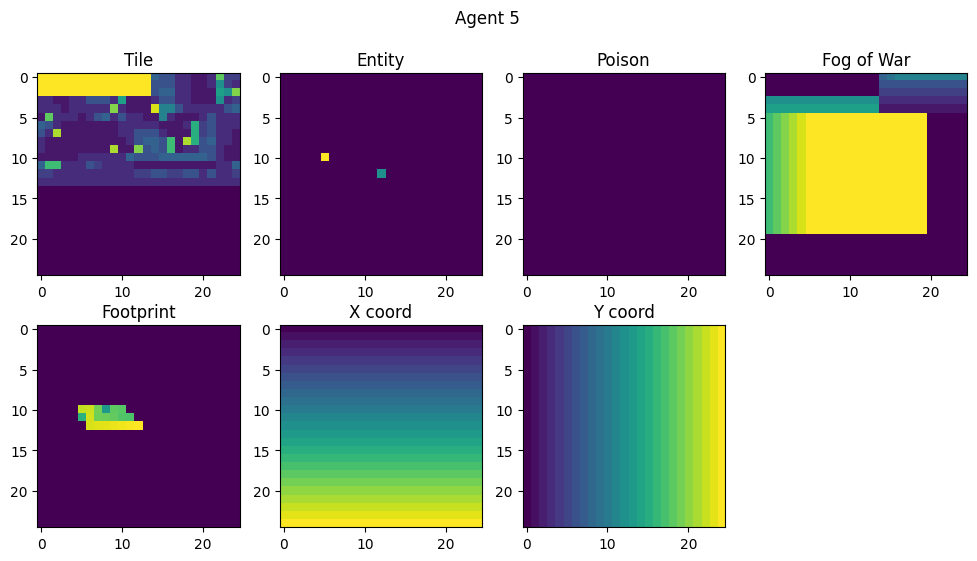

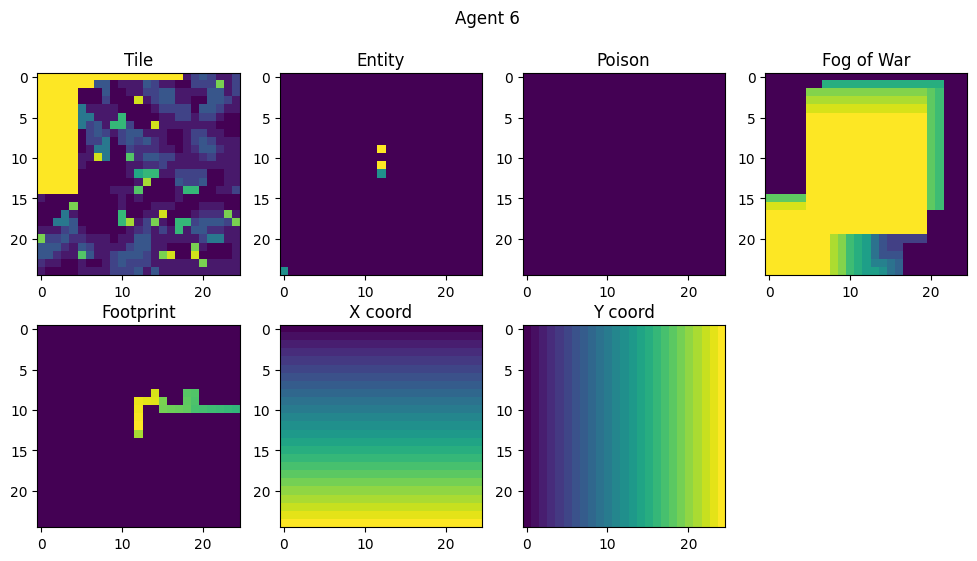

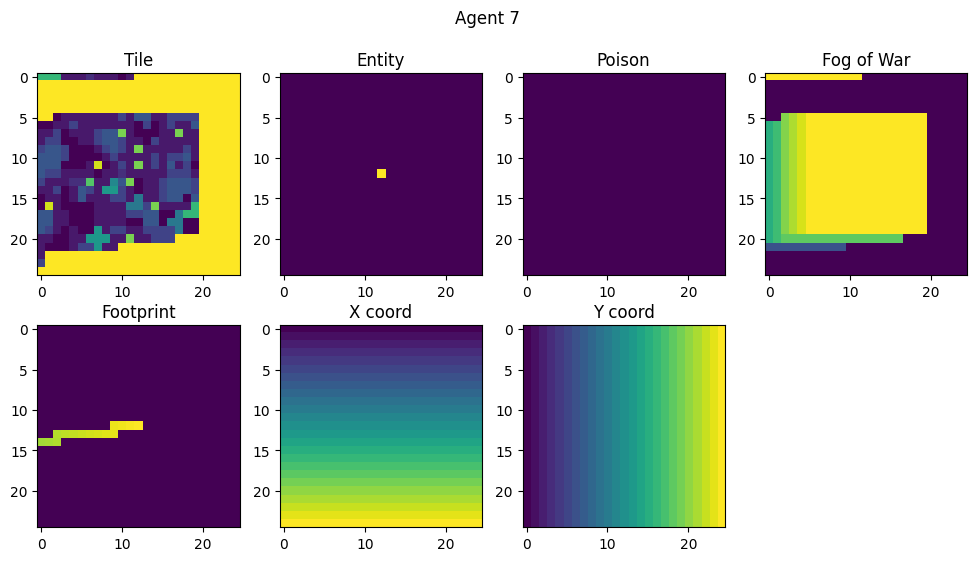

In [12]:
# should look like these feature maps
# https://github.com/Netease-Games-AI-Lab-Guangzhou/realikun/blob/master/media/features.png

tile_imgs = map_helper.extract_tile_feature()

for pl_pos_team in range(8):
  plot_tile_feats(tile_imgs[pl_pos_team], pl_pos_team)